In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import tensorboard as tb
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
from tqdm import tqdm

In [2]:
sns.set(font_scale=1.5)

In [3]:
# https://github.com/theRealSuperMario/supermariopy/blob/master/scripts/tflogs2pandas.py
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


def many_logs2pandas(event_paths):
    all_logs = pd.DataFrame()
    for path in event_paths:
        log = tflog2pandas(path)
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)
    return all_logs

In [4]:
def load_models(dir):
    all_logs = pd.DataFrame()
    models = next(os.walk(dir))[1]
    for model in tqdm(models):
        model_path = os.path.join(dir, model)
        runs = next(os.walk(model_path))[1]
        for run in runs:
            path = os.path.join(model_path, run)
            log = tflog2pandas(path)
            log['run'] = run
            log['model'] = model
            # string_splits = run.split('_')
            # log['tag'] = string_splits[0]
            # log['model'] = string_splits[1]
            # hp = ', '.join(string_splits[2:-3])
            # if string_splits[1] == 'GecoVAE':
            #     hp = hp.replace(", 255,", ",")
            #     hp = hp.replace("lambda, init", "lambda_init")
            # log['hyperparams'] = hp
            # log['seed'] = string_splits[-3][4:]
            # log['date'] = string_splits[-2] + "_" + string_splits[-1]

            if log is not None:
                if all_logs.shape[0] == 0:
                    all_logs = log
                else:
                    all_logs = all_logs.append(log, ignore_index=True)


    # create dataframe with final values
    # dff = all_logs[all_logs.step == all_logs.step.max()]
    # dff = dff.pivot_table(index=["run", "tag", "model", "hyperparams", "seed", "date"], columns=["metric"],values="value")
    # dff = pd.DataFrame(dff.to_records())
    return all_logs #, dff

In [5]:
dir = './carla/agents/data/'
df = load_models(dir)

100%|██████████| 35/35 [21:00<00:00, 36.01s/it]


In [6]:
df.to_pickle("all_ncextra.pkl")

In [10]:
# df = pd.read_pickle("26912-44864.pkl")

In [8]:
a = df
a = a[a.metric == "eval_stats/AvgEpRet"]
a = a[a.step == a.step.max()]


In [9]:
a.sort_values("value")

,metric,value,step,run,model
2601379,eval_stats/AvgEpRet,1.518928,59.0,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...
8795374,eval_stats/AvgEpRet,2.268311,59.0,carlac_frozenvae_GecoVAE_tolerance10.0_255_lam...,carlac_frozenvae_GecoVAE_tolerance10.0_255_lam...
12511709,eval_stats/AvgEpRet,2.330034,59.0,nc_s26912,nc
4725009,eval_stats/AvgEpRet,2.409311,59.0,carlac_frozenvae_BetaVAE_beta1.0_seed787727006...,carlac_frozenvae_BetaVAE_beta1.0_seed787727006
7202619,eval_stats/AvgEpRet,2.497917,59.0,carlac_frozenvae_BetaVAE_beta5.0_seed171041946...,carlac_frozenvae_BetaVAE_beta5.0_seed171041946
...,...,...,...,...,...
5963824,eval_stats/AvgEpRet,2.720022,59.0,carlac_frozenvae_BetaVAE_beta10.0_seed78772700...,carlac_frozenvae_BetaVAE_beta10.0_seed787727006
6848679,eval_stats/AvgEpRet,2.722144,59.0,carlac_frozenvae_BetaVAE_beta20.0_seed78772700...,carlac_frozenvae_BetaVAE_beta20.0_seed787727006
9503249,eval_stats/AvgEpRet,2.747844,59.0,carlac_frozenvae_GecoVAE_tolerance10.0_255_lam...,carlac_frozenvae_GecoVAE_tolerance10.0_255_lam...
12334744,eval_stats/AvgEpRet,2.751711,59.0,carlac_frozenvae_GecoVAE_tolerance5.0_255_lamb...,carlac_frozenvae_GecoVAE_tolerance5.0_255_lamb...


Text(0.5, 1.0, 'AvgEpRet at final step')

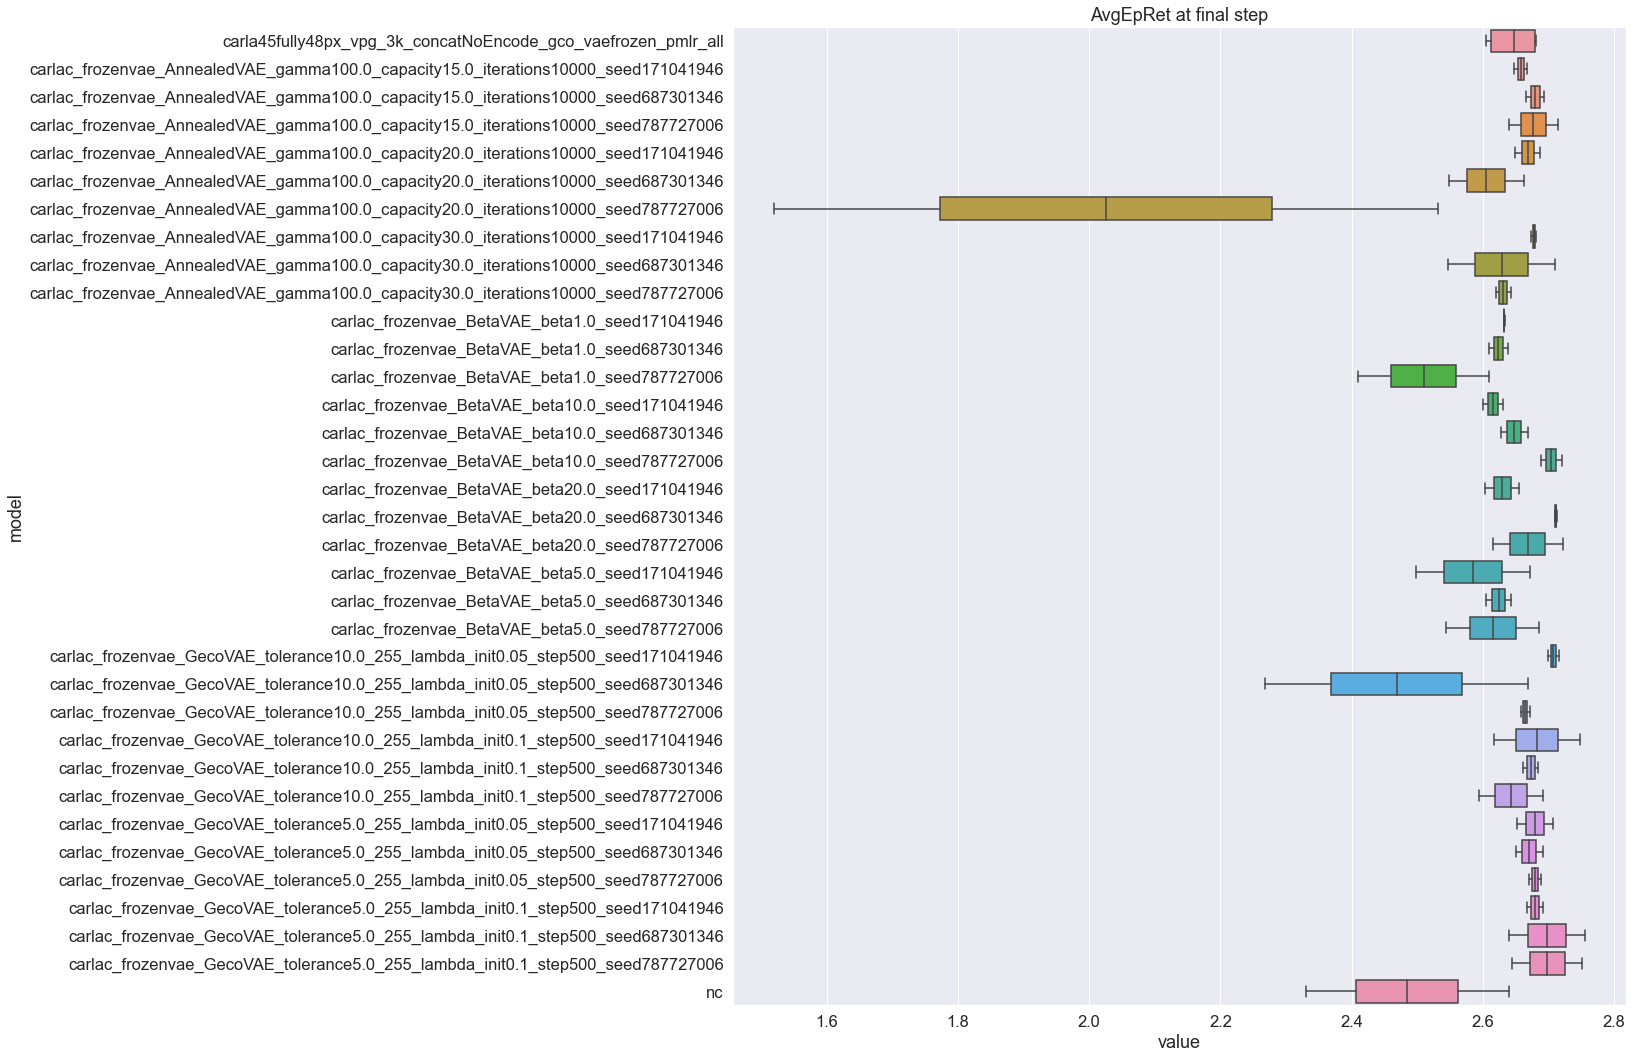

In [10]:
plt.figure(figsize=(16, 18))
sns.boxplot(data=a, y=a.model, x=a.value).set_title("Cumulative Reward")


In [11]:
import re
a['model_arch'] = a.model.apply(lambda x: 'nc' if x == 'nc' else re.findall(r'carlac_frozenvae_(\w+)_',x)[0])
a['model_hp'] = a.model.apply(lambda x: '' if x == 'nc' else re.findall(r'carlac_frozenvae_[^_]+(.*)_seed',x)[0])

IndexError: list index out of range

In [ ]:
df_mean = a.groupby(["model_arch","model_hp"]).mean()

In [ ]:
df_mean

value  step
model_arch  model_hp                                                  
AnnealedVAE _gamma100.0_capacity15.0_iterations10000    2.671723  59.0
            _gamma100.0_capacity20.0_iterations10000    2.432886  59.0
            _gamma100.0_capacity30.0_iterations10000    2.645805  59.0
BetaVAE     _beta1.0                                    2.588663  59.0
            _beta10.0                                   2.656019  59.0
            _beta20.0                                   2.669885  59.0
            _beta5.0                                    2.608079  59.0
GecoVAE     _tolerance10.0_255_lambda_init0.05_step500  2.613709  59.0
            _tolerance10.0_255_lambda_init0.1_step500   2.666075  59.0
            _tolerance5.0_255_lambda_init0.05_step500   2.676559  59.0
            _tolerance5.0_255_lambda_init0.1_step500    2.691982  59.0
nc                                                      2.484686  59.0

In [ ]:
green = sns.light_palette("green", as_cmap=True)
df_mean.style\
    .background_gradient(cmap=green, subset=['value'])

In [ ]:
df_std = a.groupby(["model_arch","model_hp"]).agg({'value': ['mean', 'std', 'max', 'count']})

In [ ]:
df_std

value            \
                                                            mean       std   
model_arch  model_hp                                                         
AnnealedVAE _gamma100.0_capacity15.0_iterations10000    2.671723  0.028039   
            _gamma100.0_capacity20.0_iterations10000    2.432886  0.452244   
            _gamma100.0_capacity30.0_iterations10000    2.645805  0.057385   
BetaVAE     _beta1.0                                    2.588663  0.088761   
            _beta10.0                                   2.656019  0.044670   
            _beta20.0                                   2.669885  0.052417   
            _beta5.0                                    2.608079  0.074311   
GecoVAE     _tolerance10.0_255_lambda_init0.05_step500  2.613709  0.170580   
            _tolerance10.0_255_lambda_init0.1_step500   2.666075  0.055288   
            _tolerance5.0_255_lambda_init0.05_step500   2.676559  0.022927   
            _tolerance5.0_255_lambda_init0.1_step500    2.691982  0.051393   
nc                                                      2.484686  0.218712   

                                                                        
                                                             max count  
model_arch  model_hp                                                    
AnnealedVAE _gamma100.0_capacity15.0_iterations10000    2.714506     6  
            _gamma100.0_capacity20.0_iterations10000    2.687217     6  
            _gamma100.0_capacity30.0_iterations10000    2.709622     6  
BetaVAE     _beta1.0                                    2.638811     6  
            _beta10.0                                   2.720022     6  
            _beta20.0                                   2.722144     6  
            _beta5.0                                    2.685917     6  
GecoVAE     _tolerance10.0_255_lambda_init0.05_step500  2.716594     6  
            _tolerance10.0_255_lambda_init0.1_step500   2.747844     6  
            _tolerance5.0_255_lambda_init0.05_step500   2.706900     6  
            _tolerance5.0_255_lambda_init0.1_step500    2.756478     6  
nc                                                      2.639339     2

Text(0.5, 1.0, 'AvgEpRet at final step')

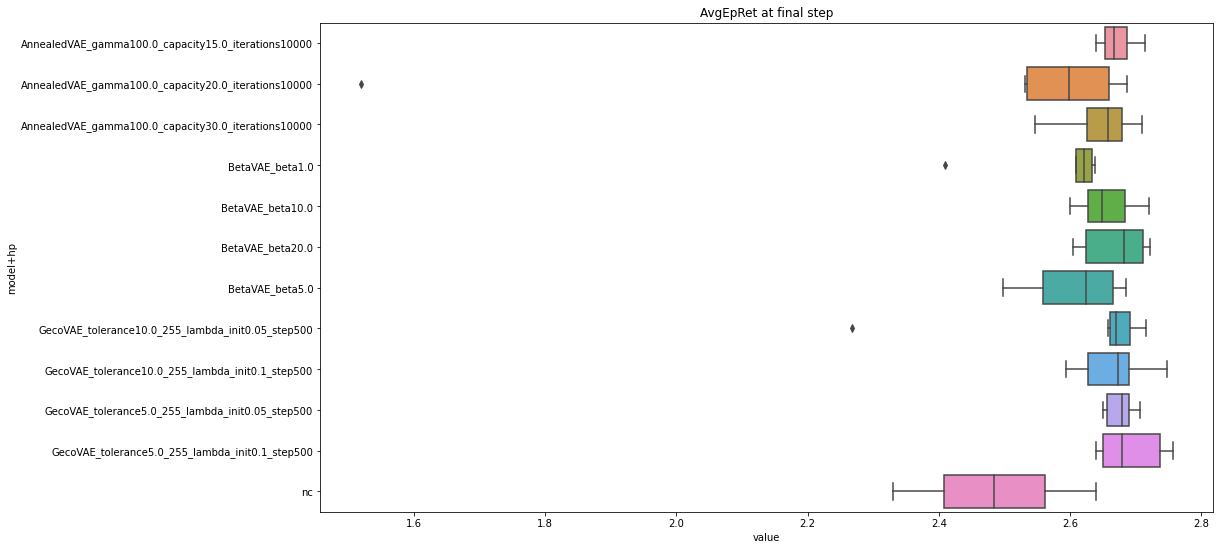

In [ ]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=a, y=a["model+hp"], x=a.value).set_title("Cumulative Reward")


In [ ]:
################################################################################################
################################################################################################
################################################################################################
################################################################################################

In [7]:
a = df
a = a[a.metric == "eval_stats/AvgEpRet"]
a = a[a.step == a.step.max()]

import re
def desc_columns(a):
    a['arch'] = a.model.apply(lambda x: 'nc' if x == 'nc' else '[Eghbal-zadeh et al., 2021]' if x == "carla45fully48px_vpg_3k_concatNoEncode_gco_vaefrozen_pmlr_all" else re.findall(r'carlac_frozenvae_(\w+)_',x)[0])
    a['hp'] = a.model.apply(lambda x: '' if x == 'nc' or x == "carla45fully48px_vpg_3k_concatNoEncode_gco_vaefrozen_pmlr_all" else re.findall(r'carlac_frozenvae_[^_]+_(.*)_seed',x)[0])

    def simplifyHp(x):
        matches = re.findall(r'gamma100\.0_capacity([0-9.]+)_iterations10000',x)
        if matches.__len__() > 0:
            x = "capacity_"+matches[0]

        matches = re.findall(r'tolerance([0-9.]+)_255_lambda_init([0-9.]+)_step500',x)
        if matches.__len__() > 0:
            x = "tolerance"+matches[0][0] + " lambda-init_"+matches[0][1]
        
        return x

    a['hp'] = a['hp'].apply(simplifyHp)
    a['name'] = a.arch +" "+ a.hp

    return a

a = desc_columns(a)

In [8]:
a

,metric,value,step,run,model,arch,hp,name
137584,eval_stats/AvgEpRet,2.604405,59.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
312004,eval_stats/AvgEpRet,2.614822,59.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
478649,eval_stats/AvgEpRet,2.679705,59.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
649884,eval_stats/AvgEpRet,2.680400,59.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
831024,eval_stats/AvgEpRet,2.667889,59.0,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...,carlac_frozenvae_AnnealedVAE_gamma100.0_capaci...,AnnealedVAE,capacity_15.0,AnnealedVAE capacity_15.0
...,...,...,...,...,...,...,...,...
24546309,eval_stats/AvgEpRet,2.639339,59.0,nc_s44864,nc,nc,,nc
24723284,eval_stats/AvgEpRet,2.540045,59.0,nc_s65066,nc,nc,,nc
24900244,eval_stats/AvgEpRet,2.707345,59.0,nc_s73735,nc,nc,,nc
25077229,eval_stats/AvgEpRet,2.713689,59.0,nc_s88994,nc,nc,,nc


In [9]:
a.groupby(["name"]).agg({'value': ['mean', 'std', 'max', "min", 'count']})

value                      \
                                            mean       std       max   
name                                                                   
AnnealedVAE capacity_15.0               2.663906  0.045186  2.733706   
AnnealedVAE capacity_20.0               2.517537  0.319139  2.687217   
AnnealedVAE capacity_30.0               2.647989  0.076630  2.742489   
BetaVAE beta1.0                         2.598387  0.070614  2.672606   
BetaVAE beta10.0                        2.643664  0.059850  2.740122   
BetaVAE beta20.0                        2.652826  0.061928  2.728972   
BetaVAE beta5.0                         2.590404  0.109388  2.685917   
GecoVAE tolerance10.0 lambda-init_0.05  2.590913  0.203951  2.716594   
GecoVAE tolerance10.0 lambda-init_0.1   2.671246  0.047755  2.747844   
GecoVAE tolerance5.0 lambda-init_0.05   2.655391  0.043149  2.706900   
GecoVAE tolerance5.0 lambda-init_0.1    2.684019  0.049433  2.756478   
[Eghbal-zadeh et al., 2021]             2.644833  0.040891  2.680400   
nc                                      2.576454  0.132282  2.713689   

                                                        
                                             min count  
name                                                    
AnnealedVAE capacity_15.0               2.564667    11  
AnnealedVAE capacity_20.0               1.518928    12  
AnnealedVAE capacity_30.0               2.469450    12  
BetaVAE beta1.0                         2.409311    12  
BetaVAE beta10.0                        2.532967    12  
BetaVAE beta20.0                        2.571078    12  
BetaVAE beta5.0                         2.302300    12  
GecoVAE tolerance10.0 lambda-init_0.05  2.075339    12  
GecoVAE tolerance10.0 lambda-init_0.1   2.593906    12  
GecoVAE tolerance5.0 lambda-init_0.05   2.564839    12  
GecoVAE tolerance5.0 lambda-init_0.1    2.619883    12  
[Eghbal-zadeh et al., 2021]             2.604405     4  
nc                                      2.330034     8

In [10]:
print(a.groupby(["name"]).agg({'value': ['mean', 'std', 'max', "min", 'count']}).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} & \multicolumn{5}{l}{value} \\
{} &      mean &       std &       max &       min & count \\
name                                   &           &           &           &           &       \\
\midrule
AnnealedVAE capacity\_15.0              &  2.663906 &  0.045186 &  2.733706 &  2.564667 &    11 \\
AnnealedVAE capacity\_20.0              &  2.517537 &  0.319139 &  2.687217 &  1.518928 &    12 \\
AnnealedVAE capacity\_30.0              &  2.647989 &  0.076630 &  2.742489 &  2.469450 &    12 \\
BetaVAE beta1.0                        &  2.598387 &  0.070614 &  2.672606 &  2.409311 &    12 \\
BetaVAE beta10.0                       &  2.643664 &  0.059850 &  2.740122 &  2.532967 &    12 \\
BetaVAE beta20.0                       &  2.652826 &  0.061928 &  2.728972 &  2.571078 &    12 \\
BetaVAE beta5.0                        &  2.590404 &  0.109388 &  2.685917 &  2.302300 &    12 \\
GecoVAE tolerance10.0 lambda-init\_0.05 &  2.590913 &  0.203951 &  2.716594

Text(0.5, 1.0, 'Cumulative Reward')

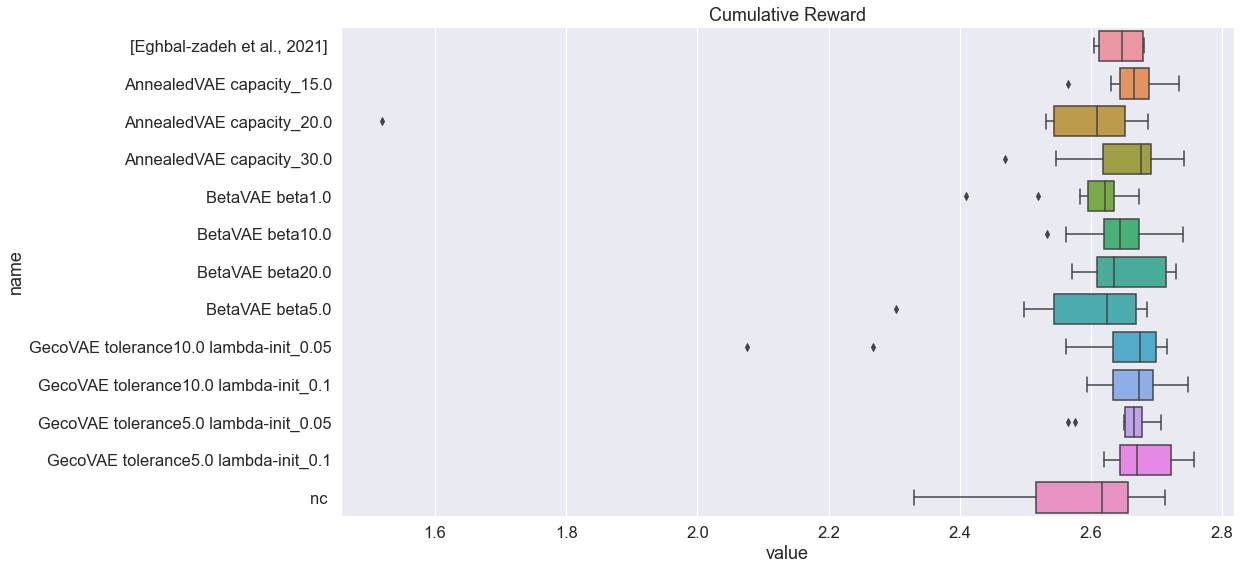

In [11]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=a, y=a["name"], x=a.value).set_title("Cumulative Reward")


In [12]:
a.name.unique()

array(['[Eghbal-zadeh et al., 2021] ', 'AnnealedVAE capacity_15.0',
       'AnnealedVAE capacity_20.0', 'AnnealedVAE capacity_30.0',
       'BetaVAE beta1.0', 'BetaVAE beta10.0', 'BetaVAE beta20.0',
       'BetaVAE beta5.0', 'GecoVAE tolerance10.0 lambda-init_0.05',
       'GecoVAE tolerance10.0 lambda-init_0.1',
       'GecoVAE tolerance5.0 lambda-init_0.05',
       'GecoVAE tolerance5.0 lambda-init_0.1', 'nc '], dtype=object)

[Text(0.5, 0, 'Cumulative Reward'), Text(0, 0.5, '')]

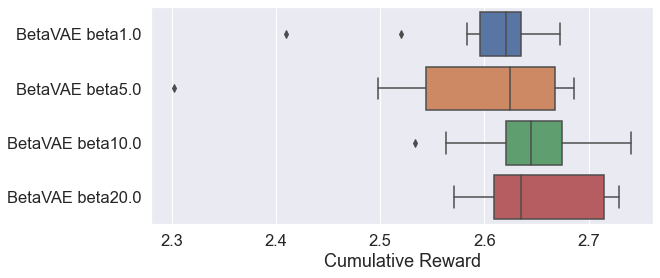

In [13]:
plt.figure(figsize=(9, 4))
sns.boxplot(data=a[a.arch == "BetaVAE"], y="name", x="value", order=["BetaVAE beta1.0", "BetaVAE beta5.0","BetaVAE beta10.0","BetaVAE beta20.0"]).set(xlabel="Cumulative Reward", ylabel=None)


[Text(0.5, 0, 'Cumulative Reward'), Text(0, 0.5, '')]

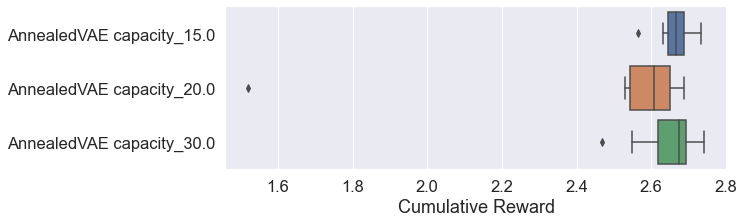

In [14]:
plt.figure(figsize=(9, 3))
sns.boxplot(data=a[a.arch == "AnnealedVAE"], y="name", x="value", ).set(xlabel="Cumulative Reward", ylabel=None)


[Text(0.5, 0, 'Cumulative Reward'), Text(0, 0.5, '')]

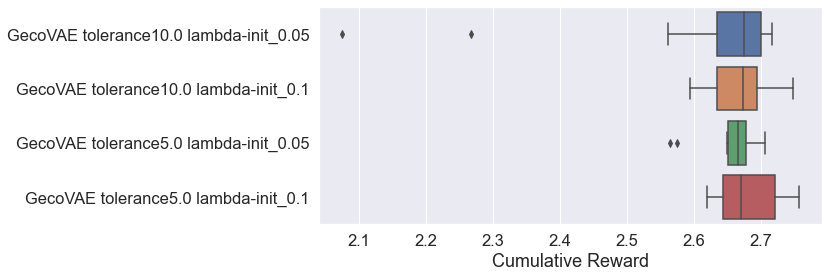

In [15]:
plt.figure(figsize=(9, 4))
sns.boxplot(data=a[a.arch == "GecoVAE"], y="name", x="value").set(xlabel="Cumulative Reward", ylabel=None)


[Text(0.5, 0, 'Cumulative Reward'), Text(0, 0.5, '')]

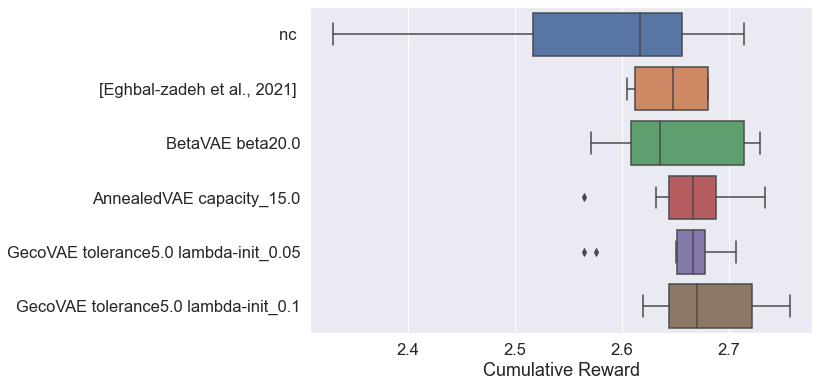

In [16]:
clist = ["nc ", "[Eghbal-zadeh et al., 2021] ", "BetaVAE beta20.0", "AnnealedVAE capacity_15.0", "GecoVAE tolerance5.0 lambda-init_0.05", "GecoVAE tolerance5.0 lambda-init_0.1"]
c = a[a.name.isin(clist)]
plt.figure(figsize=(9, 6))
order = clist
sns.boxplot(data=c, y="name", x="value", order=order).set(xlabel="Cumulative Reward", ylabel=None)


In [17]:
df = desc_columns(df)

In [18]:
tlist = ["nc ", "[Eghbal-zadeh et al., 2021] ", "GecoVAE tolerance5.0 lambda-init_0.1"]
t = df[df.name.isin(tlist)]

In [19]:
t

,metric,value,step,run,model,arch,hp,name
0,stats/EpRet,-0.559556,0.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
1,stats/EpRet,-0.657292,1.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
2,stats/EpRet,-0.557609,2.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
3,stats/EpRet,-0.496042,3.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
4,stats/EpRet,-0.221509,4.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
...,...,...,...,...,...,...,...,...
25281400,eval_stats/context_89/GoalReached,1.000000,55.0,nc_s94869,nc,nc,,nc
25281401,eval_stats/context_89/GoalReached,1.000000,56.0,nc_s94869,nc,nc,,nc
25281402,eval_stats/context_89/GoalReached,0.900000,57.0,nc_s94869,nc,nc,,nc
25281403,eval_stats/context_89/GoalReached,0.950000,58.0,nc_s94869,nc,nc,,nc


Text(0.5, 1.0, 'reward by Config')

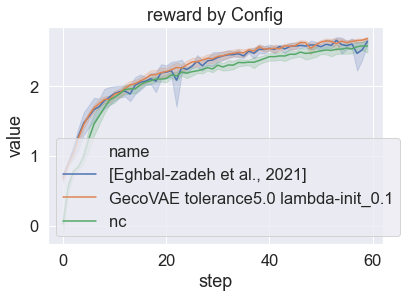

In [20]:
sns.lineplot(data=t[t.metric == "eval_stats/AvgEpRet"], x="step", y="value", hue="name").set_title("reward by Config")


Text(0.5, 1.0, 'GOD0.7 by Config')

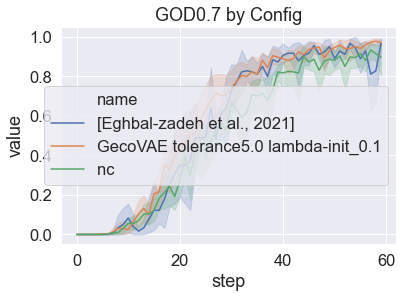

In [21]:
sns.lineplot(data=t[t.metric == "eval_stats/GOD_0.7"], x="step", y="value", hue="name").set_title("GOD0.7 by Config")


In [22]:
df

,metric,value,step,run,model,arch,hp,name
0,stats/EpRet,-0.559556,0.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
1,stats/EpRet,-0.657292,1.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
2,stats/EpRet,-0.557609,2.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
3,stats/EpRet,-0.496042,3.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
4,stats/EpRet,-0.221509,4.0,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,carla45fully48px_vpg_3k_concatNoEncode_gco_vae...,"[Eghbal-zadeh et al., 2021]",,"[Eghbal-zadeh et al., 2021]"
...,...,...,...,...,...,...,...,...
25281400,eval_stats/context_89/GoalReached,1.000000,55.0,nc_s94869,nc,nc,,nc
25281401,eval_stats/context_89/GoalReached,1.000000,56.0,nc_s94869,nc,nc,,nc
25281402,eval_stats/context_89/GoalReached,0.900000,57.0,nc_s94869,nc,nc,,nc
25281403,eval_stats/context_89/GoalReached,0.950000,58.0,nc_s94869,nc,nc,,nc


In [23]:
#df.to_pickle("rl.pkl")

[Text(0.5, 0, 'Avg GOD Score'), Text(0, 0.5, '')]

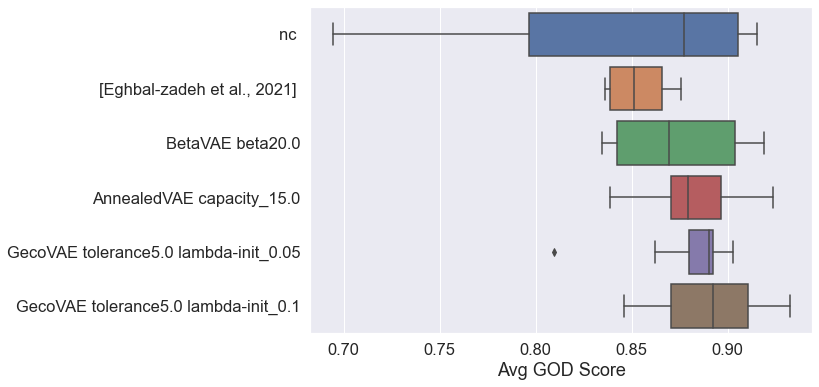

In [34]:
clist = ["nc ", "[Eghbal-zadeh et al., 2021] ", "BetaVAE beta20.0", "AnnealedVAE capacity_15.0", "GecoVAE tolerance5.0 lambda-init_0.05", "GecoVAE tolerance5.0 lambda-init_0.1"]
a = df
a = a[a.metric == "eval_stats/AvgScore"]
a = a[a.step == a.step.max()]
c = a[a.name.isin(clist)]
plt.figure(figsize=(9, 6))
order = clist
sns.boxplot(data=c, y="name", x="value", order=order).set(xlabel="Avg GOD Score", ylabel=None)


In [35]:
c[c['arch'] == "nc"]

,metric,value,step,run,model,arch,hp,name
24015539,eval_stats/AvgScore,0.765000,59.0,nc_s24946,nc,nc,,nc
24192504,eval_stats/AvgScore,0.694444,59.0,nc_s26912,nc,nc,,nc
24369459,eval_stats/AvgScore,0.902778,59.0,nc_s34416,nc,nc,,nc
24546429,eval_stats/AvgScore,0.909444,59.0,nc_s44864,nc,nc,,nc
24723404,eval_stats/AvgScore,0.807222,59.0,nc_s65066,nc,nc,,nc
24900364,eval_stats/AvgScore,0.903889,59.0,nc_s73735,nc,nc,,nc
25077349,eval_stats/AvgScore,0.915000,59.0,nc_s88994,nc,nc,,nc
25254344,eval_stats/AvgScore,0.851667,59.0,nc_s94869,nc,nc,,nc


In [42]:
c[c['arch'] == "[Eghbal-zadeh et al., 2021]"][['run', 'value']].values

array([['carla45fully48px_vpg_3k_concatNoEncode_gco_vaefrozen_pmlr_all_s65066',
        0.8394442796707153],
       ['carla45fully48px_vpg_3k_concatNoEncode_gco_vaefrozen_pmlr_all_s73735',
        0.8361111879348755],
       ['carla45fully48px_vpg_3k_concatNoEncode_gco_vaefrozen_pmlr_all_s88994',
        0.8755555748939514],
       ['carla45fully48px_vpg_3k_concatNoEncode_gco_vaefrozen_pmlr_all_s94869',
        0.8627777695655823]], dtype=object)

In [46]:
c[c['arch'] == "nc"]['value'].mean(), c[c['arch'] == "[Eghbal-zadeh et al., 2021]"]['value'].mean()

(0.8436805605888367, 0.8534722030162811)

[Text(0.5, 0, 'GOD_0.7'), Text(0, 0.5, '')]

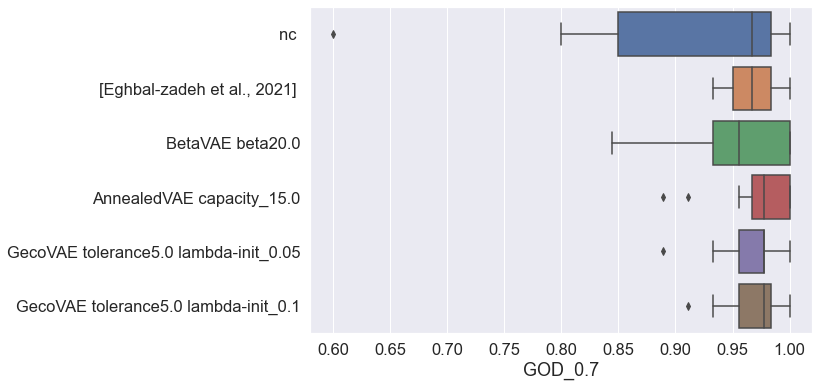

In [29]:
clist = ["nc ", "[Eghbal-zadeh et al., 2021] ", "BetaVAE beta20.0", "AnnealedVAE capacity_15.0", "GecoVAE tolerance5.0 lambda-init_0.05", "GecoVAE tolerance5.0 lambda-init_0.1"]
a = df
a = a[a.metric == "eval_stats/GOD_0.7"]
a = a[a.step == a.step.max()]
c = a[a.name.isin(clist)]
plt.figure(figsize=(9, 6))
order = clist
sns.boxplot(data=c, y="name", x="value", order=order).set(xlabel="GOD_0.7", ylabel=None)
